In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
file_path = "/content/StockData.csv"
df_raw = pd.read_csv(file_path)

df_raw.head()

,APPL,Unnamed: 1,SPY,Unnamed: 3,QQQ,Unnamed: 5
0,Date,Close,Date,Close,Date,Close
1,1/3/2023 16:00:00,125.07,1/3/2023 16:00:00,380.82,1/3/2023 16:00:00,264.48
2,1/4/2023 16:00:00,126.36,1/4/2023 16:00:00,383.76,1/4/2023 16:00:00,265.74
3,1/5/2023 16:00:00,125.02,1/5/2023 16:00:00,379.38,1/5/2023 16:00:00,261.58
4,1/6/2023 16:00:00,129.62,1/6/2023 16:00:00,388.08,1/6/2023 16:00:00,268.8


In [16]:
df_uploaded = pd.read_csv("/content/StockData.csv")

df_uploaded.columns = df_uploaded.columns.str.strip()

# Build cleaned DataFrame
df = pd.DataFrame({
    'Date': pd.to_datetime(df_uploaded['Date']),
    'AAPL': df_uploaded['Close'],
    'SPY': df_uploaded['Close.1'],
    'QQQ': df_uploaded['Close.2']
})

df.set_index('Date', inplace=True)
df = df.apply(pd.to_numeric, errors='coerce').dropna()

df.head()

,AAPL,SPY,QQQ
Date,,,
2023-01-03 16:00:00,125.07,380.82,264.48
2023-01-04 16:00:00,126.36,383.76,265.74
2023-01-05 16:00:00,125.02,379.38,261.58
2023-01-06 16:00:00,129.62,388.08,268.80
2023-01-09 16:00:00,130.15,387.86,270.54


In [17]:
# Log returns: ln(P_t / P_{t-1})
log_returns = np.log(df / df.shift(1)).dropna()
log_returns.head()

,AAPL,SPY,QQQ
Date,,,
2023-01-04 16:00:00,0.010261,0.007691,0.004753
2023-01-05 16:00:00,-0.010661,-0.011479,-0.015778
2023-01-06 16:00:00,0.036133,0.022673,0.027227
2023-01-09 16:00:00,0.004081,-0.000567,0.006452
2023-01-10 16:00:00,0.004446,0.006988,0.008429


In [18]:
# Mean and covariance of log returns
mu = log_returns.mean()
cov = log_returns.cov()

# Kelly weights
kelly_weights = np.linalg.inv(cov).dot(mu)
kelly_weights /= kelly_weights.sum()  # normalize to 100% total

pd.Series(kelly_weights, index=log_returns.columns)

,0
AAPL,0.829178
SPY,-4.539176
QQQ,4.709998


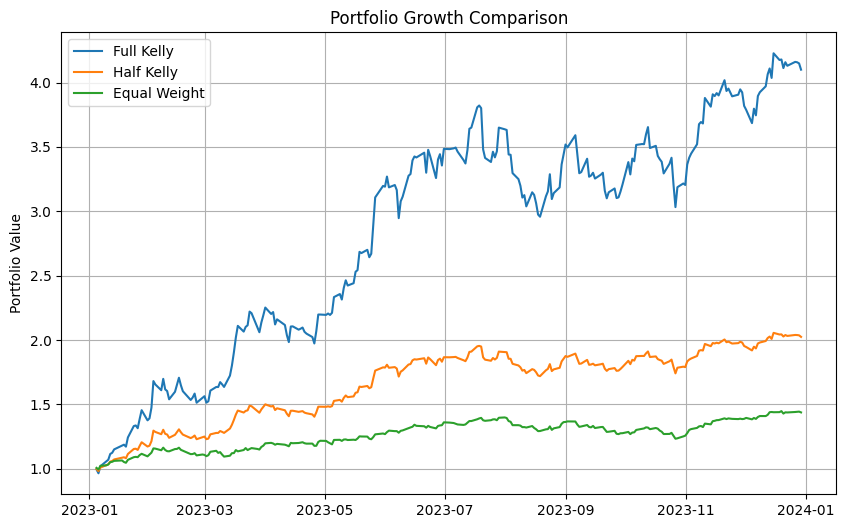

In [19]:
def simulate_growth(weights, log_returns, initial=1.0):
    cumulative_log_returns = log_returns.dot(weights).cumsum()
    return np.exp(cumulative_log_returns) * initial

# Simulate different strategies
kelly_growth = simulate_growth(kelly_weights, log_returns)
half_kelly_growth = simulate_growth(kelly_weights * 0.5, log_returns)
equal_weights = np.ones(len(kelly_weights)) / len(kelly_weights)
equal_growth = simulate_growth(equal_weights, log_returns)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(kelly_growth, label='Full Kelly')
plt.plot(half_kelly_growth, label='Half Kelly')
plt.plot(equal_growth, label='Equal Weight')
plt.title('Portfolio Growth Comparison')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
from scipy.optimize import minimize

# Objective: negative Sharpe ratio
def neg_sharpe(weights, mu, cov, risk_free=0.0):
    port_return = np.dot(mu, weights)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return - (port_return - risk_free) / port_vol

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(mu)))  # long-only

# Initial guess
x0 = np.ones(len(mu)) / len(mu)

# Optimize
opt = minimize(neg_sharpe, x0=x0, args=(mu, cov), bounds=bounds, constraints=constraints)
mpt_weights = opt.x
pd.Series(mpt_weights, index=log_returns.columns)

,0
AAPL,2.536830e-01
SPY,2.046974e-16
QQQ,7.463170e-01


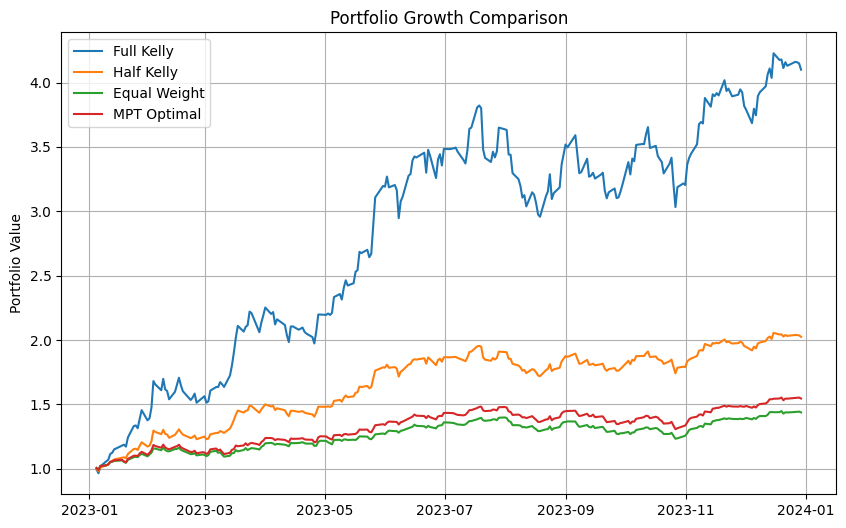

In [21]:
mpt_growth = simulate_growth(mpt_weights, log_returns)

# Plot again with MPT
plt.figure(figsize=(10, 6))
plt.plot(kelly_growth, label='Full Kelly')
plt.plot(half_kelly_growth, label='Half Kelly')
plt.plot(equal_growth, label='Equal Weight')
plt.plot(mpt_growth, label='MPT Optimal')
plt.title('Portfolio Growth Comparison')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
def risk_metrics(cumulative, label='Strategy'):
    returns = np.log(cumulative / cumulative.shift(1)).dropna()
    max_drawdown = (cumulative / cumulative.cummax() - 1).min()
    sharpe = returns.mean() / returns.std() * np.sqrt(252)
    return pd.Series({'Sharpe Ratio': sharpe, 'Max Drawdown': max_drawdown}, name=label)

results = pd.concat([
    risk_metrics(kelly_growth, 'Full Kelly'),
    risk_metrics(half_kelly_growth, 'Half Kelly'),
    risk_metrics(equal_growth, 'Equal Weight'),
    risk_metrics(mpt_growth, 'MPT Optimal'),
], axis=1)

results.T

,Sharpe Ratio,Max Drawdown
Full Kelly,2.923710,-0.226014
Half Kelly,2.923710,-0.120235
Equal Weight,2.291814,-0.118174
MPT Optimal,2.496860,-0.118079


In [23]:
results.T

,Sharpe Ratio,Max Drawdown
Full Kelly,2.923710,-0.226014
Half Kelly,2.923710,-0.120235
Equal Weight,2.291814,-0.118174
MPT Optimal,2.496860,-0.118079


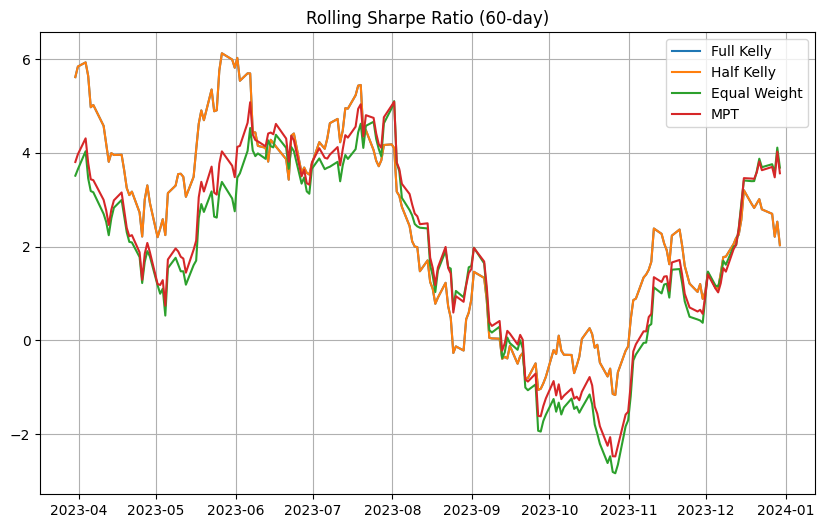

In [24]:
def rolling_sharpe(log_returns, weights, window=60):
    rolling = log_returns.dot(weights).rolling(window=window)
    return rolling.mean() / rolling.std() * np.sqrt(252)

rolling_kelly = rolling_sharpe(log_returns, kelly_weights)
rolling_half = rolling_sharpe(log_returns, kelly_weights * 0.5)
rolling_equal = rolling_sharpe(log_returns, equal_weights)
rolling_mpt = rolling_sharpe(log_returns, mpt_weights)

# Plot
plt.figure(figsize=(10,6))
plt.plot(rolling_kelly, label='Full Kelly')
plt.plot(rolling_half, label='Half Kelly')
plt.plot(rolling_equal, label='Equal Weight')
plt.plot(rolling_mpt, label='MPT')
plt.title('Rolling Sharpe Ratio (60-day)')
plt.legend()
plt.grid(True)
plt.show()

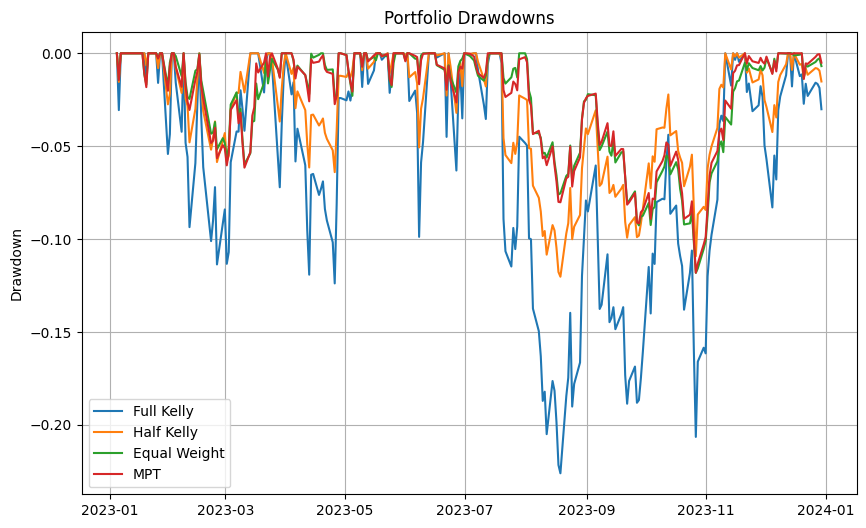

In [25]:
def drawdown_curve(cumulative):
    return cumulative / cumulative.cummax() - 1

plt.figure(figsize=(10,6))
plt.plot(drawdown_curve(kelly_growth), label='Full Kelly')
plt.plot(drawdown_curve(half_kelly_growth), label='Half Kelly')
plt.plot(drawdown_curve(equal_growth), label='Equal Weight')
plt.plot(drawdown_curve(mpt_growth), label='MPT')
plt.title('Portfolio Drawdowns')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

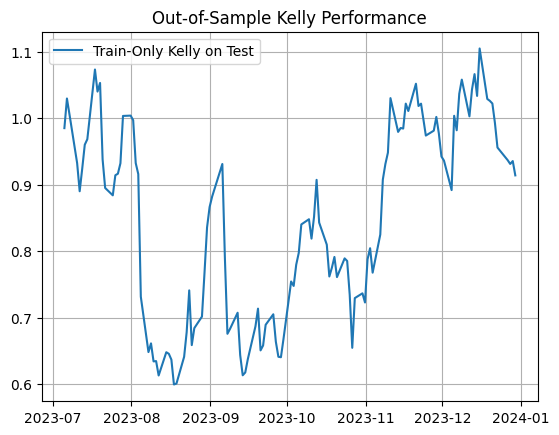

In [26]:
midpoint = len(log_returns) // 2
train = log_returns.iloc[:midpoint]
test = log_returns.iloc[midpoint:]

kelly_train_weights = np.linalg.inv(train.cov()).dot(train.mean())
kelly_train_weights /= kelly_train_weights.sum()

# Apply to test period
kelly_test_growth = simulate_growth(kelly_train_weights, test)

plt.plot(kelly_test_growth, label="Train-Only Kelly on Test")
plt.title("Out-of-Sample Kelly Performance")
plt.legend()
plt.grid(True)
plt.show()